In [1]:
!pip install box2d-py
!pip3 install box2d-py==2.3.8

In [2]:
from keras.models import Model, model_from_json, load_model
from keras.optimizers import Adam, RMSprop
import os
from keras.layers import Input, Dense
import keras.backend as K
import time
from copy import deepcopy
import numpy as np
import gym
from collections import deque
import random

Using TensorFlow backend.


In [3]:
'''class Memory:
    def __init__(self):
        self.batch_s = []
        self.batch_a = []
        self.batch_r = []
        self.batch_s_ = []
        self.batch_done = []

    def store(self, s, a, s_, r, done):
        self.batch_s.append(s)
        self.batch_a.append(a)
        self.batch_r.append(r)
        self.batch_s_.append(s_)
        self.batch_done.append(done)

    def clear(self):
        self.batch_s.clear()
        self.batch_a.clear()
        self.batch_r.clear()
        self.batch_s_.clear()
        self.batch_done.clear()

    @property
    def cnt_samples(self):
        return len(self.batch_s)
'''

'class Memory:\n    def __init__(self):\n        self.batch_s = []\n        self.batch_a = []\n        self.batch_r = []\n        self.batch_s_ = []\n        self.batch_done = []\n\n    def store(self, s, a, s_, r, done):\n        self.batch_s.append(s)\n        self.batch_a.append(a)\n        self.batch_r.append(r)\n        self.batch_s_.append(s_)\n        self.batch_done.append(done)\n\n    def clear(self):\n        self.batch_s.clear()\n        self.batch_a.clear()\n        self.batch_r.clear()\n        self.batch_s_.clear()\n        self.batch_done.clear()\n\n    @property\n    def cnt_samples(self):\n        return len(self.batch_s)\n'

In [0]:
def stack_samples(samples):
	array = np.array(samples)
	#print(array)
	current_states = np.stack(array[:,0]).reshape((array.shape[0],-1))
	actions = np.stack(array[:,1]).reshape((array.shape[0],-1))
	new_states = np.stack(array[:,2]).reshape((array.shape[0],-1))
	rewards= np.stack(array[:,3]).reshape((array.shape[0],-1))
	dones = np.stack(array[:,4]).reshape((array.shape[0],-1))
	#print('done')
	return current_states, actions, new_states,rewards , dones
	

In [0]:
class Agent:
  def __init__(self,state_dim =(8, ),n_actions=3 ,alpha=1e-3,beta=3e-3,batch_size=32,gamma=0.99,FC1dims=32,FC2dims=16,Clipping_loss_ratio=0.2,Entorpy_loss_Ratio = 0.2,Tau=0.9):
    self.state_dim = state_dim
    self.alpha = alpha
    self.beta = beta
    self.batch_size = batch_size
    self.gamma = gamma
    self.FC1dims = FC1dims
    self.FC2dims = FC2dims
    self.Clipping_loss_ratio = Clipping_loss_ratio
    self.Entorpy_loss_Ratio = Entorpy_loss_Ratio
    self.Tau = Tau
    self.n_actions = n_actions
    self.actor_network = self._build_actor_network()
    self.actor_old_network = self.build_network_from_copy(self.actor_network)
    self.critic_network = self._build_critic_network()
    self.dummy_advantage = np.zeros((1, 1))
    self.dummy_old_prediction = np.zeros((1, self.n_actions))
    self.memory = deque(maxlen=1000000)
  def choose_action(self, state):
        assert isinstance(state, np.ndarray), "state must be numpy.ndarry"

        state = np.reshape(state, [-1, self.state_dim[0]])
        prob = self.actor_network.predict_on_batch([state, self.dummy_advantage, self.dummy_old_prediction]).flatten()
        action = np.random.choice(self.n_actions, p=prob)
        return action
  def train_network(self):
        n = len(self.memory)
        if n<self.batch_size:
          return
        samples = random.sample(self.memory, self.batch_size)
        states, actions, next_states, rewards, dones = stack_samples(samples)
        #print(next_states)
        discounted_r = []
        if dones[-1]:
            v = 0
        else:
            v = self.get_Q(next_states)
        discounted_r = np.add(v,rewards*self.gamma)
        #for r in rewards[::-1]:
         #   v = r + self.gamma * v
         #   discounted_r.append(v)
        #print(discounted_r)
        #discounted_r.reverse()

        batch_s, batch_a, batch_discounted_r = np.vstack(states),np.vstack(actions),np.vstack(discounted_r)
        batch_v = self.get_Q(batch_s)
        batch_advantage = batch_discounted_r - batch_v
        batch_old_prediction = self.get_old_prediction(batch_s)

        batch_a_final = np.zeros(shape=(len(batch_a), self.n_actions))
        batch_a_final[:, batch_a.flatten()] = 1
        # print(batch_s.shape, batch_advantage.shape, batch_old_prediction.shape, batch_a_final.shape)
        self.actor_network.fit(x=[batch_s, batch_advantage, batch_old_prediction], y=batch_a_final, verbose=0)
        self.critic_network.fit(x=batch_s, y=batch_discounted_r, epochs=2, verbose=0)
        
        self.update_target_network()
  def get_old_prediction(self, s):
        s = np.reshape(s, (-1, self.state_dim[0]))
        
        return self.actor_old_network.predict_on_batch(s)

  def store_transition(self, s, a, s_, r, done):
        #print(s_)
        self.memory.append([s, a, s_, r, done])

  def get_Q(self, s):
        #print(s)
        s = np.reshape(s, (-1, self.state_dim[0]))
        #print('done')
        Q = self.critic_network.predict_on_batch(s)
        return Q
  
  def _build_actor_network(self):

        state = Input(shape=self.state_dim, name="state")

        advantage = Input(shape=(1, ), name="Advantage")
        old_prediction = Input(shape=(self.n_actions,), name="Old_Prediction")

        shared_hidden = self._shared_network_structure(state)

        action_dim = self.n_actions

        policy = Dense(action_dim, activation="softmax", name="actor_output_layer")(shared_hidden)

        actor_network = Model(inputs=[state, advantage, old_prediction], outputs=policy)

        
        actor_network.compile(optimizer=Adam(lr=self.alpha),
                                  loss=self.proximal_policy_optimization_loss(
                                    advantage=advantage, old_prediction=old_prediction,
                                  ))      
        actor_network.summary()
        return actor_network

  def update_target_network(self):
        Tau = self.Tau
        self.actor_old_network.set_weights(Tau*np.array(self.actor_network.get_weights())
                                           + (1-Tau)*np.array(self.actor_old_network.get_weights()))
  def _build_critic_network(self):
        state = Input(shape=self.state_dim, name="state")
        shared_hidden = self._shared_network_structure(state)        
        q = Dense(1, name="critic_output_layer")(shared_hidden)
        critic_network = Model(inputs=state, outputs=q)        
        critic_network.compile(optimizer=Adam(lr=self.beta),
                                   loss="mean_squared_error")
        
        print("=== Build Critic Network ===")
        critic_network.summary()

        #time.sleep(1.0)
        return critic_network
   
  def build_network_from_copy(self, actor_network):
        network_structure = actor_network.to_json()
        network_weights = actor_network.get_weights()
        network = model_from_json(network_structure)
        network.set_weights(network_weights)
        network.compile(optimizer=Adam(lr=self.alpha), loss="mse")
        return network

  def _shared_network_structure(self, state_features):
        dense_d = self.FC1dims
        hidden1 = Dense(dense_d, activation="relu", name="hidden_shared_1")(state_features)
        hidden2 = Dense(self.FC2dims, activation="relu", name="hidden_shared_2")(hidden1)
        return hidden2

  def proximal_policy_optimization_loss(self, advantage, old_prediction):
        loss_clipping = self.Clipping_loss_ratio
        entropy_loss = self.Entorpy_loss_Ratio

        def loss(y_true, y_pred):
            prob =  y_pred
            old_prob =  old_prediction
            r = prob / (old_prob + 1e-10)
            return -K.mean(K.minimum(r * advantage, K.clip(r, min_value=1 - loss_clipping,
                                                           max_value=1 + loss_clipping) * advantage) )

        return loss


In [8]:
env = gym.make("LunarLander-v2")
  #print(env.action_space)

agent = Agent()
episodes = 1000
score_history = []
for i in range(episodes):
    #print('trail:'+str(i))
    cur_state = env.reset()
    done=False
    score = 0
    step=0
    while not done:
      step+=1
      
      #print(cur_state)
      #print('--------------')
      action = agent.choose_action(cur_state)
      #print(action)
      #action = action.reshape((1,env.action_space.shape[0]))
      #clipped_action = np.clip(action,  env.action_space.low, env.action_space.high)
      #action = np.argmax(action)
      #print(action)
      new_state,reward,done,info = env.step(action)
      #print(new_state)
      score+=reward
      #if step % agent.batch_size == 0:
      agent.train_network()      
      agent.store_transition(cur_state,action,new_state,reward,done)
      cur_state = new_state
    score_history.append(score)
    print('episode:',i,'score:',score)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 8)                 0         
_________________________________________________________________
hidden_shared_1 (Dense)      (None, 32)                288       
_________________________________________________________________
hidden_shared_2 (Dense)      (None, 16)                528       
_________________________________________________________________
actor_output_layer (Dense)   (None, 3)                 51        
Total params: 867
Trainable params: 867
Non-trainable params: 0
_________________________________________________________________
=== Build Critic Network ===
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 8)                 0         
_______________

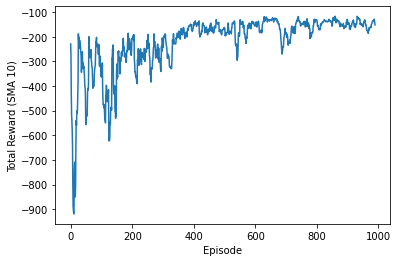

In [9]:
import matplotlib.pyplot as plt
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(score_history[tr:tr+window]) for tr in range(window, len(score_history))])